In [67]:
import numpy as np
import fenics
import scipy.sparse as sps
import scipy.sparse.linalg as spla
# from fenics_to_scipy_sparse_csr_conversion import convert_fenics_csr_matrix_to_scipy_csr_matrix, vec2fct
from fenics_interactive_impulse_response_plot import fenics_interactive_impulse_response_plot
import matplotlib.pyplot as plt
from fenics_function_smoother import FenicsFunctionSmoother
from fenics_function_fast_grid_evaluator import FenicsFunctionFastGridEvaluator
from mesh_makers import circle_mesh
from random_fenics_function_makers import random_smooth_partition_of_unity, FenicsSmoothFunctionMaker, randn_fenics_function
from plot_ellipse import plot_ellipse
from interpolate_matrices import interpolate_matrices
from make_fenics_amg_solver import make_fenics_amg_solver
from poisson_interpolation import PoissonSquaredInterpolation
from localpsf_helpers import *
from localpsf import *
import hlibpro_experiments1 as hpro

In [2]:
fine_mesh_h=5e-3
mesh_h= 3e-2 #5e-2
finite_element_order=1
final_time_T=5e-4
num_timesteps=35
noise_level=5e-3
mesh_center = np.array([0.5,0.5])
mesh_radius = 0.5
num_random_matrices_for_conductivity_field=4
conductivity_interpolation_temperature=3
boundary_tol = 0.5
num_std_dev_tau=3

In [3]:
np.random.seed(1)

In [4]:
fine_mesh = circle_mesh(mesh_center, mesh_radius, 1./fine_mesh_h)
fine_V = fenics.FunctionSpace(fine_mesh, 'CG', finite_element_order)

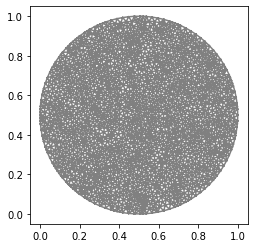

In [141]:
mesh = circle_mesh(mesh_center, mesh_radius, 1./mesh_h)
V = fenics.FunctionSpace(mesh, 'CG', finite_element_order)
fenics.plot(mesh)

X = V.tabulate_dof_coordinates()
N = V.dim()
d = mesh.geometric_dimension()

Make conductivity field $\kappa$ defined by
$$\kappa_{ij}(x) := \sum_{k=1}^4 w_k(x)\left(C_k\right)_{ij}$$
where $C_k$ are randomish matrices and $w_k$ are randomish smooth fields.

We build the functions $w_k$ on a very fine grid that always stays the same for reproducibility, then interpolate them to different coarser grid for different runs/numerical experiments.

In [6]:
fine_ww = random_smooth_partition_of_unity(num_random_matrices_for_conductivity_field, fine_V, 
                                           temperature=conductivity_interpolation_temperature, normalize=True)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [7]:
for fw in fine_ww:
    fw.set_allow_extrapolation(True)
    
ww = [fenics.interpolate(fw, V) for fw in fine_ww]

In [8]:
C0 = np.array([[0.50,  0.25],
               [0.25,  0.25]])
C1 = np.array([[ 0.50, -0.40],
               [-0.40,  0.50]])
C2 = np.array([[ 1.70, -0.10],
               [-0.10,  4.10]])
C3 = np.array([[ 1.90, -0.25],
               [-0.25,  0.60]])
CC = [C0, C1, C2, C3]

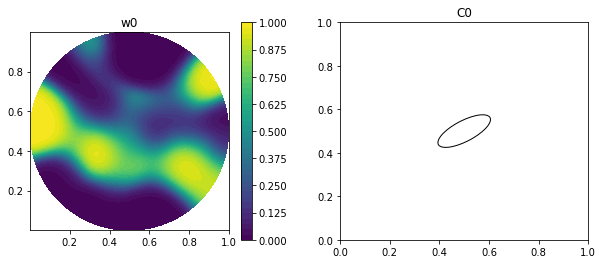

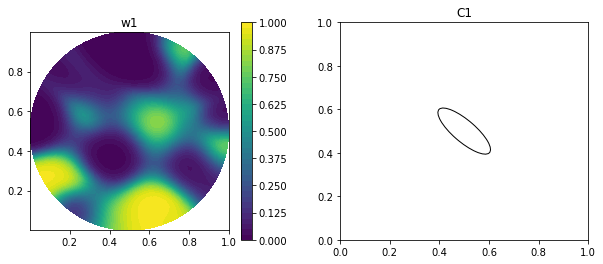

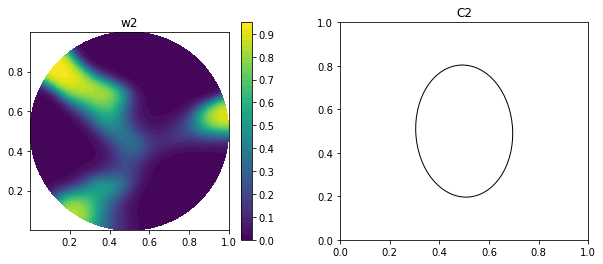

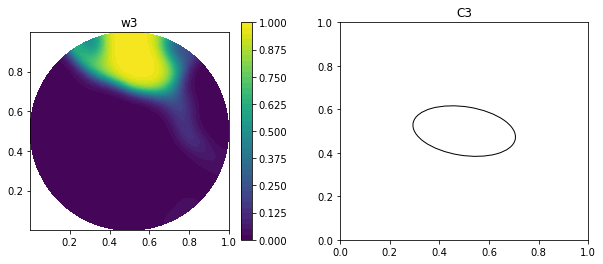

In [9]:
nw = len(ww)
for k in range(nw):
    f = plt.figure()
    f.set_figwidth(10)
    
    plt.subplot(1,2,1)
    c = fenics.plot(ww[k])
    plt.colorbar(c)
    plt.title('w'+str(k))
    
    ax = plt.subplot(1,2,2)
    plot_ellipse(ax, np.array([0.5,0.5]), CC[k], 0.15)
    plt.title('C'+str(k))
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    plt.subplots_adjust(wspace=0.25)

$$u_t = -\nabla \cdot \kappa \nabla u$$
Input at $u(0)$
Observations at $t=T$

In [10]:
kappa = interpolate_matrices(ww, CC)

Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/nick/repos/localpsf/code/plot_ellipse.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi


Text(0.5, 1.0, 'kappa')

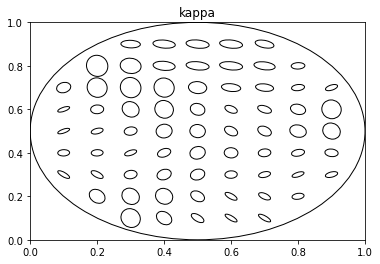

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_ellipse(ax, mesh_center, np.eye(2), mesh_radius)

xx = np.linspace(0., 1., 11)
yy = np.linspace(0., 1., 11)

for ii in range(len(xx)):
    for jj in range(len(yy)):
        mu = np.array([xx[ii], yy[jj]])
        if np.linalg.norm(mu - mesh_center) < mesh_radius:
            Sigma = kappa(np.array(mu)).reshape((2,2))
            plot_ellipse(ax, mu, Sigma, 0.025)
            
plt.title('kappa')

In [12]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)

mass_form = u_trial * v_test * fenics.dx
M = fenics.assemble(mass_form)
solve_M = make_fenics_amg_solver(M)

stiffness_form = fenics.inner(kappa * fenics.grad(u_trial), fenics.grad(v_test)) * fenics.dx
A = fenics.assemble(stiffness_form)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [13]:
delta_t = final_time_T / num_timesteps
Z_minus = M
Z_plus = M + delta_t * A

solve_Z_plus = make_fenics_amg_solver(Z_plus)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FF

Text(0.5, 1.0, 'u0_true')

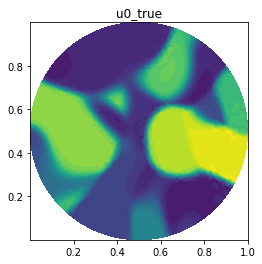

In [14]:
zz = random_smooth_partition_of_unity(25, V, temperature=10, normalize=True)

u0_true = fenics.Function(V)
for k in range(len(zz)):
    u0_true.vector()[:] = u0_true.vector() + (k**2) * zz[k].vector()
fenics.plot(u0_true)
plt.title('u0_true')

In [15]:
def forward_map(u0_petsc):
    uT_petsc = fenics.Vector(u0_petsc)
    for k in range(num_timesteps):
        uT_petsc = solve_Z_plus(Z_minus * uT_petsc)
    return uT_petsc

Text(0.5, 1.0, 'uT_true')

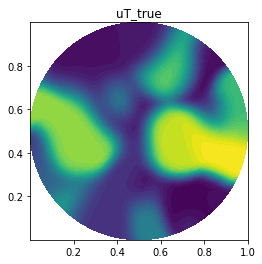

In [16]:
uT_true = fenics.Function(V)
uT_true.vector()[:] = forward_map(u0_true.vector())
fenics.plot(uT_true)
plt.title('uT_true')

In [17]:
def adjoint_map(vT_petsc):
    v0_petsc = fenics.Vector(vT_petsc)
    for k in range(num_timesteps):
        v0_petsc = Z_minus * solve_Z_plus(v0_petsc)
    return v0_petsc

Perform adjoint correctness check

In [18]:
x = randn_fenics_function(V)
y = randn_fenics_function(V)
adjoint_err = np.abs(forward_map(x.vector()).inner(y.vector())
                     - x.vector().inner(adjoint_map(y.vector())))
print('adjoint_err=', adjoint_err)

adjoint_err= 8.886123836759907e-09


true_noise_level= 0.004985346610013144


Text(0.5, 1.0, 'uT_obs')

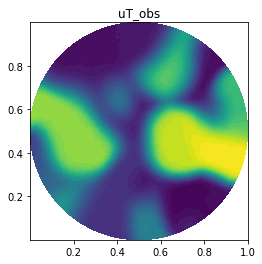

In [19]:
N = V.dim() 
normalized_noise = np.random.randn(N) / np.sqrt(N)
uT_obs = fenics.Function(V)
uT_obs.vector()[:] = uT_true.vector()[:] + noise_level * normalized_noise * np.linalg.norm(uT_true.vector()[:])

true_noise_level = fenics.norm(uT_obs.vector() - uT_true.vector())/fenics.norm(uT_true.vector())
print('true_noise_level=', true_noise_level)
fenics.plot(uT_obs)
plt.title('uT_obs')

In [20]:
def objective(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    J = 0.5 * discrepancy.inner(M * discrepancy)
    return J

In [21]:
objective(u0_true.vector())

0.427337163653132

In [22]:
def gradient(u0_petsc):
    uT_petsc = forward_map(u0_petsc)
    discrepancy = uT_petsc - uT_obs.vector()
    return adjoint_map(M * discrepancy)

In [23]:
def apply_hessian(p_petsc):
    return adjoint_map(M * forward_map(p_petsc))

apply_H = apply_hessian
apply_Ht = apply_hessian

## Finite difference check for gradient and Hessian

In [24]:
u0 = fenics.Function(V)
u0.vector()[:] = np.random.randn(V.dim())

J = objective(u0.vector())
g = gradient(u0.vector())

du = fenics.Function(V)
du.vector()[:] = np.random.randn(V.dim())

In [25]:
ss = np.logspace(-15, 0, 11)
grad_errs = np.zeros(len(ss))
for k in range(len(ss)):
    s = ss[k]
    u0_2_vector = u0.vector() + s * du.vector()

    J2 = objective(u0_2_vector)
    dJ_diff = (J2 - J) / s
    dJ = g.inner(du.vector())
    grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)
    grad_errs[k] = grad_err

    print('s=', s, ', grad_err=', grad_err)

<ipython-input-25-a19fad4e0606>:10: RuntimeWarning: divide by zero encountered in double_scalars
  grad_err = np.abs(dJ - dJ_diff) / np.abs(dJ_diff)


s= 1e-15 , grad_err= inf
s= 3.1622776601683796e-14 , grad_err= inf
s= 1e-12 , grad_err= inf
s= 3.1622776601683794e-11 , grad_err= 0.04191546402524378
s= 1e-09 , grad_err= 0.001188134725573753
s= 3.162277660168379e-08 , grad_err= 8.824214483932897e-05
s= 1e-06 , grad_err= 2.344255682900746e-06
s= 3.1622776601683795e-05 , grad_err= 1.3640956275478205e-07
s= 0.001 , grad_err= 3.7857293621285788e-06
s= 0.03162277660168379 , grad_err= 0.00011969631228550349
s= 1.0 , grad_err= 0.0037713015720305582


hess_err= 5.981242495087334e-10


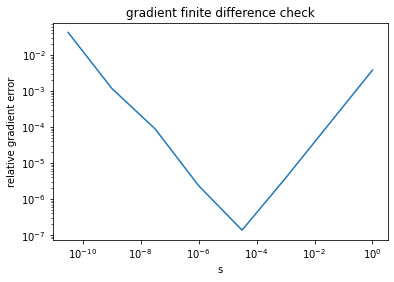

In [26]:
plt.figure()
plt.loglog(ss, grad_errs)
plt.title('gradient finite difference check')
plt.xlabel('s')
plt.ylabel('relative gradient error')

u0_2 = fenics.Function(V)
u0_2.vector()[:] = np.random.randn(V.dim())
dg = apply_hessian(u0_2.vector() - u0.vector())
g2 = gradient(u0_2.vector())
dg_diff = g2 - g
hess_err = fenics.norm(dg - dg_diff) / fenics.norm(dg_diff)
print('hess_err=', hess_err)

## Visualize Hessian impulse responses

Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, 'point source at [0.2 0.5]')

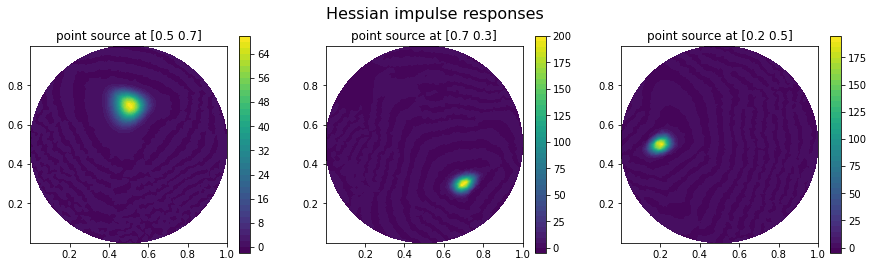

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
fig.suptitle('Hessian impulse responses', fontsize=16)

plt.sca(axes[0])
pp = np.array([[0.5,0.7]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_H, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[1])
pp = np.array([[0.7,0.3]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_H, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

plt.sca(axes[2])
pp = np.array([[0.2,0.5]])
Hdc = get_hessian_dirac_comb_response(pp, V, apply_H, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
plt.title('point source at '+str(pp[0,:]))

## Get spatially varying volume

In [28]:
vol = compute_spatially_varying_volume(V, apply_Ht, solve_M)

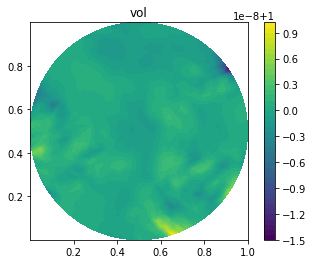

In [29]:
cmap = fenics.plot(vol)
plt.colorbar(cmap)
plt.title('vol')

vol.set_allow_extrapolation(True)

## Get spatially varying mean $\mu$

In [30]:
mu = compute_spatially_varying_mean(V, apply_Ht, solve_M, vol)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, 'mean y-component')

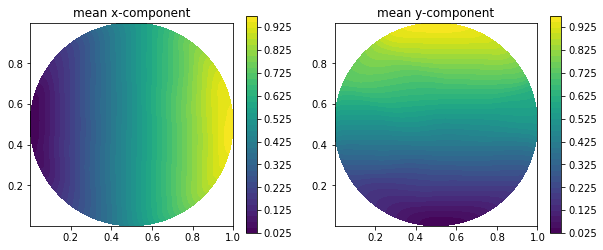

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

plt.sca(axes[0])
cmap = fenics.plot(mu.sub(0))
plt.colorbar(cmap)
plt.title('mean x-component')

plt.sca(axes[1])
cmap = fenics.plot(mu.sub(1))
plt.colorbar(cmap)
plt.title('mean y-component')

## Get spatially varying covariance $\Sigma$

In [32]:
Sigma = get_spatially_varying_covariance(V, apply_Ht, solve_M, vol, mu)

Calling FFC just-in-time (JIT) compiler, this may take some time.


/home/nick/repos/localpsf/code/plot_ellipse.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  theta = np.arctan(v_big[1] / v_big[0]) * 180. / np.pi


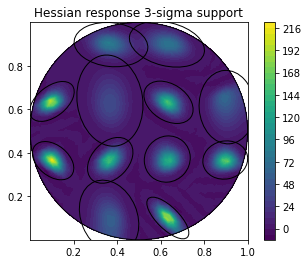

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_ellipse(ax, mesh_center, np.eye(2), mesh_radius)

xx = np.linspace(0.1, 0.9, 4)
yy = np.linspace(0.1, 0.9, 4)

pp = []
for ii in range(len(xx)):
    for jj in range(len(yy)):
        p = np.array([xx[ii], yy[jj]])
        if np.linalg.norm(p - mesh_center) < mesh_radius:
            pp.append(p)

pp = np.array(pp)

Hdc = get_hessian_dirac_comb_response(pp, V, apply_H, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)
            
plt.title('Hessian response 3-sigma support')

for k in range(pp.shape[0]):
    p = pp[k,:]
    mu_p = mu(p)
    C_p = Sigma(p).reshape((d,d))
    plot_ellipse(ax, mu_p, C_p, 3)

## Get boundary region

In [34]:
boundary_function = get_boundary_function(V, apply_Ht, solve_M)

Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, 'boundary_indicator')

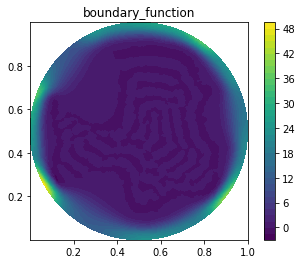

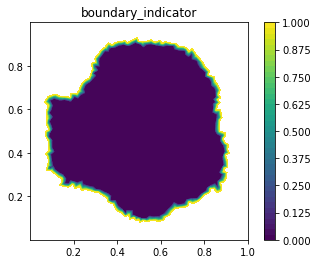

In [35]:
cmap = fenics.plot(boundary_function)
plt.colorbar(cmap)
plt.title('boundary_function')

boundary_indicator = fenics.Function(V)
boundary_indicator.vector()[:] = (np.abs(boundary_function.vector()[:]) >= boundary_tol)
boundary_inds = np.where(boundary_indicator.vector()[:])[0]

plt.figure()
cmap = fenics.plot(boundary_indicator)
plt.colorbar(cmap)
plt.title('boundary_indicator')

## Make fast evaluators

In [36]:
eval_boundary_function = FenicsFunctionFastGridEvaluator(boundary_function)
eval_vol = FenicsFunctionFastGridEvaluator(vol)
eval_mu = FenicsFunctionFastGridEvaluator(mu)
eval_Sigma = FenicsFunctionFastGridEvaluator(Sigma)

In [37]:
interior_inds = (abs(eval_boundary_function(X)) < boundary_tol)
candidate_points = X[interior_inds, :]
candidate_mu = eval_mu(candidate_points)
candidate_Sigma = eval_Sigma(candidate_points).reshape((-1,d,d))
candidate_inds = list(range(candidate_points.shape[0]))

## Choose one batch of points

In [38]:
N_cur = len(candidate_inds)
cur_mu = candidate_mu[candidate_inds, :]
cur_Sigma = candidate_Sigma[candidate_inds, :, :]

In [39]:
batch_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
batch_points = candidate_points[batch_inds,:]

/home/nick/repos/localpsf/code/localpsf_helpers.py:61: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  if ellipsoids_intersect(Sigma_perm[x_ind, :, :], Sigma_perm[p_ind, :, :], mu_perm[x_ind, :],


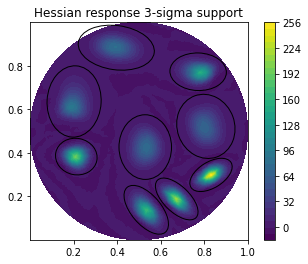

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

Hdc = get_hessian_dirac_comb_response(batch_points, V, apply_H, solve_M)
cmap = fenics.plot(Hdc)
plt.colorbar(cmap)

plt.title('Hessian response 3-sigma support')

for k in range(batch_points.shape[0]):
    p = batch_points[k,:]
    mu_p = mu(p)
    C_p = Sigma(p).reshape((d,d))
    plot_ellipse(ax, mu_p, C_p, num_std_dev_tau)

## Build Poisson interpolant

In [41]:
PSI = PoissonSquaredInterpolation(V)
PSI.add_points([batch_points[k,:] for k in range(batch_points.shape[0])])

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


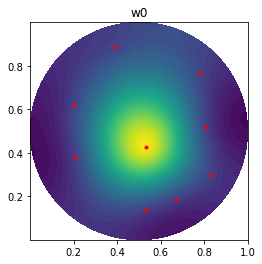

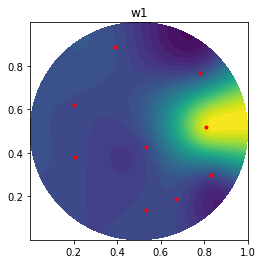

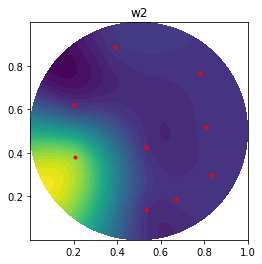

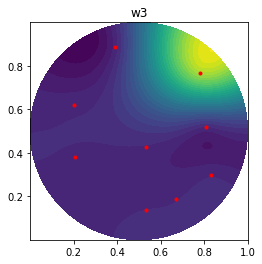

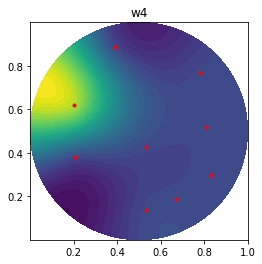

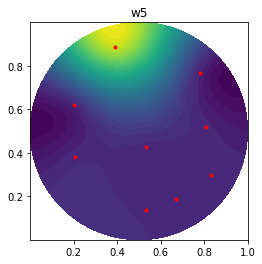

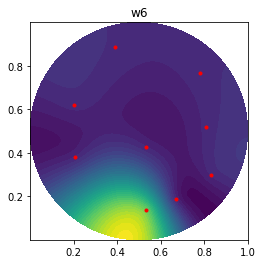

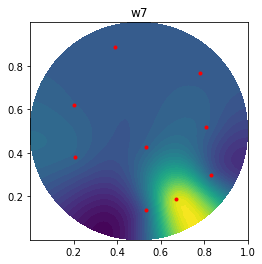

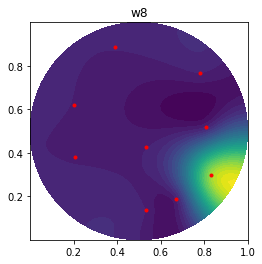

In [42]:
def plot_kth_weighting_function(k):
    fenics.plot(PSI.weighting_functions[k])
    for x in PSI.points:
        plt.plot(x[0], x[1], '.r')

for k in range(len(PSI.points)):
    plt.figure()
    plot_kth_weighting_function(k)
    plt.title('w'+str(k))

## Interpolate impulse response at a point

In [43]:
all_eval_eta = [FenicsFunctionFastGridEvaluator(Hdc)]
all_eval_ww_batches = [[FenicsFunctionFastGridEvaluator(w) for w in PSI.weighting_functions]]
point_batches = [batch_points]
all_mu_batches = [eval_mu(batch_points)]
all_Sigma_batches = [eval_Sigma(batch_points).reshape((-1,d,d))]

BPC = BatchProductConvolution(all_eval_eta, all_eval_ww_batches, point_batches, 
                              all_mu_batches, all_Sigma_batches, num_std_dev_tau)

err_Phi= 0.13208420412130104
Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, 'Phi_approx - Phi_true')

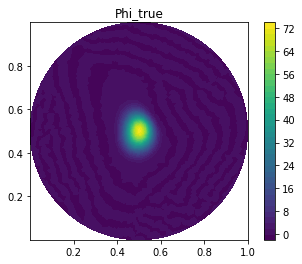

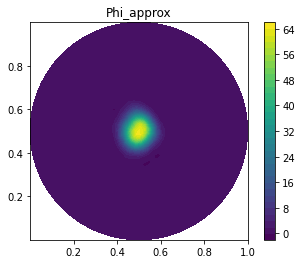

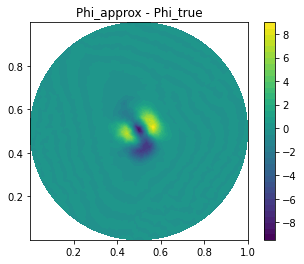

In [44]:
q0 = np.array([[0.5,0.5]])
qq = np.dot(np.ones((X.shape[0],1)), q0)
Phi_approx = fenics.Function(V)
Phi_approx.vector()[:] = BPC.compute_product_convolution_entries(X, qq)

Phi_true = get_hessian_dirac_comb_response(q0, V, apply_H, solve_M)

err_Phi = fenics.norm(Phi_approx.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
print('err_Phi=', err_Phi)

cmap = fenics.plot(Phi_true)
plt.colorbar(cmap)
plt.title('Phi_true')

plt.figure()
cmap = fenics.plot(Phi_approx)
plt.colorbar(cmap)
plt.title('Phi_approx')

plt.figure()
cmap = fenics.plot(Phi_approx - Phi_true)
plt.colorbar(cmap)
plt.title('Phi_approx - Phi_true')

## Do full approximation

$H(q,p)$ is one entry of the Hessian.

Step 1: coluomn of the Hessian
$$H(~\cdot~,p)$$

Step 2: shifted Hessian entry
$$T(q,p) := H(q + p,p)$$

For $p \in \Omega$ and $q \in \Omega$

We define the impulse response function $\varphi_x(y)$ as follows:
$$\varphi_p(q) := T(q,p) =  H(q+p,p)$$

Know: $\varphi_{p_k}$, at points $k=1,\dots,r$

Want: $\varphi_{p}$ at point a different point $p$

$$\widetilde{T}(q,p) := \varphi_{p}(q) := \sum_{k=1}^r \varphi_{p_k}(q) w_k(p)$$

for some weighting functions $w_k$, $k=1,\dots,r$

We can evaluate $\widetilde{T}(q,p)$ easily

$$H(a,b) = H(a+h,b+h)$$

say $p:=b+h$

$$H(a,p-h+h) = H(a+h,p)$$

In [45]:
lpsf = LocalPSF(apply_H, apply_Ht, V, max_batches=5)

making mass matrix and solver
getting boundary function
getting spatially varying volume
getting spatially varying mean
getting spatially varying covariance
constructing fast evaluators
done


err_Phi= 0.13208420412130104
err_Phi2= 0.1929666273493032


Text(0.5, 1.0, 'Phi_true')

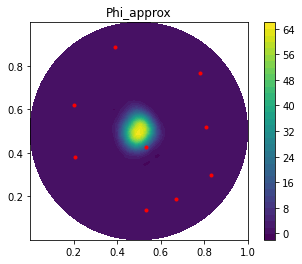

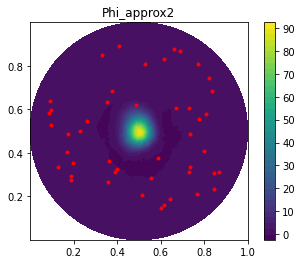

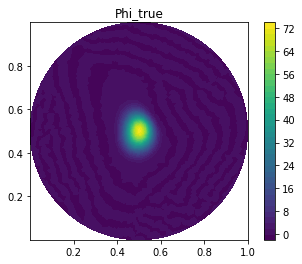

In [46]:
q0 = np.array([[0.50,0.50]])
qq = np.dot(np.ones((X.shape[0],1)), q0)
Phi_approx = fenics.Function(V)
Phi_approx.vector()[:] = BPC.compute_product_convolution_entries(X, qq)

Phi_true = get_hessian_dirac_comb_response(q0, V, apply_H, solve_M)

Phi_approx2 = fenics.Function(V)
Phi_approx2.vector()[:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)

err_Phi = fenics.norm(Phi_approx.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
print('err_Phi=', err_Phi)

err_Phi2 = fenics.norm(Phi_approx2.vector() - Phi_true.vector())/fenics.norm(Phi_true.vector())
print('err_Phi2=', err_Phi2)

cm = fenics.plot(Phi_approx)
plt.colorbar(cm)
plt.title('Phi_approx')

for x in PSI.points:
    plt.plot(x[0], x[1], '.r')

plt.figure()
cm = fenics.plot(Phi_approx2)
plt.colorbar(cm)
plt.title('Phi_approx2')

for x in lpsf.PSI.points:
    plt.plot(x[0], x[1], '.r')

plt.figure()
cm = fenics.plot(Phi_true)
plt.colorbar(cm)
plt.title('Phi_true')

In [47]:
ek = fenics.Function(V).vector()
A_true = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    ek[:] = 0.
    ek[k] = 1.
    A_true[:,k] = apply_H(ek)[:]

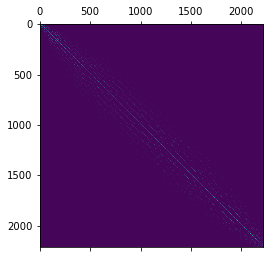

In [48]:
plt.matshow(A_true)

In [49]:
iM_A_iM = np.zeros((V.dim(), V.dim()))
for k in range(V.dim()):
    q0 = X[k,:].reshape((1,-1))
    qq = np.dot(np.ones((V.dim(),1)), q0)
    iM_A_iM[k,:] = lpsf.evaluate_approximate_hessian_entries_at_points_yy_xx(X, qq)[:]
    

In [50]:
M_numpy = M.array()
A_approx = np.dot(M_numpy, np.dot(iM_A_iM, M_numpy))
# A_approx = np.dot(M_numpy, iM_A_iM)

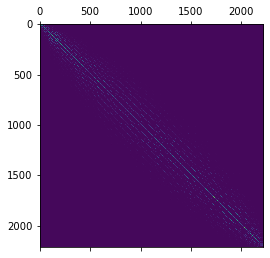

In [51]:
plt.matshow(A_approx)

In [52]:
np.linalg.norm(A_approx - A_true)/np.linalg.norm(A_true)

0.23061821231252275

In [53]:
lpsf.r

46

In [68]:
hpro.initialize_hlibpro()

In [193]:
class FenicsRegularGridInterpolator2D: 
    # https://github.com/NickAlger/helper_functions/blob/master/interpolate_fenics_function_onto_regular_grid.ipynb
    def __init__(me, function_space_V, grid_oversampling_parameter=2.0):
        me.V = function_space_V
        me.mesh = me.V.mesh()
        me.eta = grid_oversampling_parameter

        me.X = V.tabulate_dof_coordinates()
        me.min_point = np.min(me.X, axis=0)
        me.max_point = np.max(me.X, axis=0)
        
        me.nn = (me.eta * (me.max_point - me.min_point) / me.mesh.hmin()).astype(int)
        me.bounding_box_mesh = fenics.RectangleMesh(fenics.Point(me.min_point), 
                                                    fenics.Point(me.max_point), 
                                                    me.nn[0], me.nn[1])
        
        me.V_grid = fenics.FunctionSpace(me.bounding_box_mesh, 'CG', 1)
        me.X_grid = me.V_grid.tabulate_dof_coordinates()
        
        me.sort_inds = np.lexsort(me.X_grid.T)
        
        me.xx = np.linspace(me.min_point[0], me.max_point[0], me.nn[0]+1)
        me.yy = np.linspace(me.min_point[1], me.max_point[1], me.nn[1]+1)
        
    def interpolate_function(me, u):
        u.set_allow_extrapolation(True)
        u_grid = fenics.interpolate(u, me.V_grid)
        U = u_grid.vector()[me.sort_inds].reshape(me.nn+1)
        return U
    
FRGI = FenicsRegularGridInterpolator2D(V)
grid_xmin = FRGI.min_point[0]
grid_xmax = FRGI.max_point[0]
grid_ymin = FRGI.min_point[1]
grid_ymax = FRGI.max_point[1]

Text(0.5, 1.0, 'ff_grid')

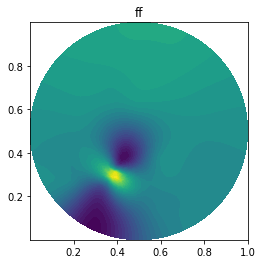

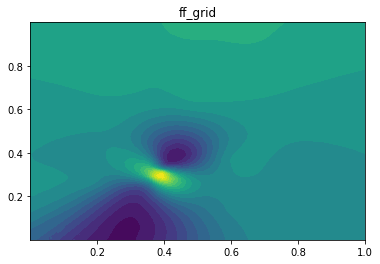

In [192]:
ff = lpsf.weighting_functions[4]
ff.set_allow_extrapolation(True)
FF = FRGI.interpolate_function(ff)
Xg, Yg = np.meshgrid(FRGI.xx, FRGI.yy, indexing='xy')


fenics.plot(ff)
plt.title('ff')
plt.figure()
plt.contourf(Xg, Yg, FF, levels=20)
plt.title('ff_grid')

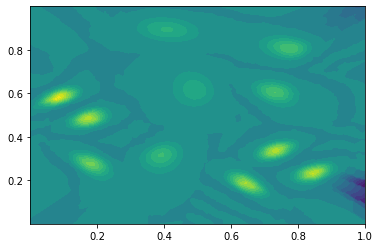

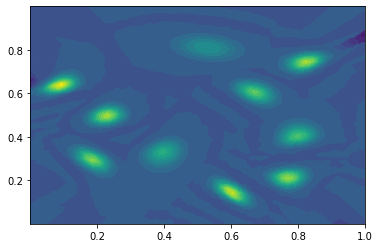

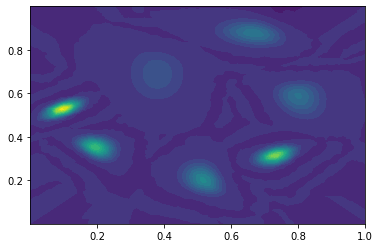

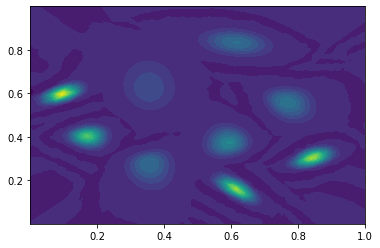

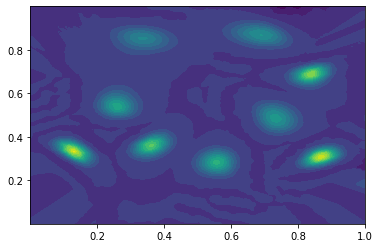

In [195]:
eta_array_batches = [FRGI.interpolate_function(eta) for eta in lpsf.dirac_comb_responses]

for ETA in eta_array_batches:
    plt.figure()
    plt.contourf(Xg, Yg, ETA, levels=20)

In [ ]:
# ww_array_batches = list()
# for k in range(len(lpsf.))

In [87]:
Sigma_batches_recursive_list = list()
for Sigma_batch in lpsf.Sigma_batches:
    Sigma_batches_recursive_list.append([Sigma_batch[k,:,:] for k in range(Sigma_batch.shape[0])])

In [74]:
ct = hpro.build_cluster_tree_from_dof_coords(X, 60)
hpro.visualize_cluster_tree(ct, "heat_inverse_problem_cluster_tree")

In [75]:
bct = hpro.build_block_cluster_tree(ct, ct, 2.0)
hpro.visualize_block_cluster_tree(bct, "heat_inverse_problem_block_cluster_tree")

In [ ]:
np.array(PSI.points)
pcb_multi = hpro.ProductConvolutionMultipleBatches(eta_array_batches,
                                                                   ww_array_batches,
                                                                   lpsf.point_batches,
                                                                   lpsf.mu_batches,
                                                                   Sigma_batches_recursive_list,
                                                                   tau, xmin, xmax, ymin, ymax)

In [ ]:
log_coeffn = hpro.CustomTLogCoeffFn(dof_coords, xmin, xmax, ymin, ymax, V)
A_hmatrix = hpro.build_hmatrix(log_coeffn, ct, ct, bct, 1e-4)
hpro.add_identity_to_hmatrix(A_hmatrix, 20.0)
hpro.visualize_hmatrix(A_hmatrix, "hmatrix_from_python")

x = np.random.randn(dof_coords.shape[0])
y = hpro.hmatrix_matvec(A_hmatrix, ct, ct, x)

inv_A = hpro.hmatrix_factorized_inverse_destructive(A_hmatrix, 1e-4)
x2 = hpro.hmatrix_factorized_inverse_matvec(inv_A, ct, ct, y)

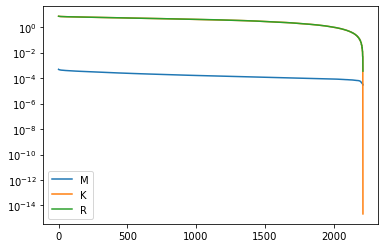

In [54]:
u_trial = fenics.TrialFunction(V)
v_test = fenics.TestFunction(V)
k_form = fenics.inner(fenics.grad(u_trial), fenics.grad(v_test))*fenics.dx
K = fenics.assemble(k_form)
K_numpy = K.array()

Reg = K_numpy + 1e0*M_numpy

_,ssM,_ = np.linalg.svd(M_numpy)
_,ssK,_ = np.linalg.svd(K_numpy)
_,ssR,_ = np.linalg.svd(Reg)

plt.semilogy(ssM)
plt.semilogy(ssK)
plt.semilogy(ssR)
plt.legend(['M', 'K', 'R'])

In [55]:
a_reg = 2e-5
H_true = A_true + a_reg * Reg
H_true = (H_true + H_true.T)/2.
H_approx0 = A_approx + a_reg * Reg
H_approx = (H_approx0 + H_approx0.T)/2.

In [56]:
U,ss_true,_ = np.linalg.svd(A_true)
ss_approx = np.abs(np.diagonal(np.dot(U.T,np.dot(A_approx,U))))
ss_reg = np.diagonal(np.dot(U.T,np.dot(Reg,U)))

Text(0, 0.5, 'lambda_i')

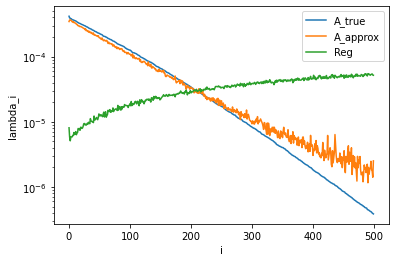

In [57]:
plt.semilogy(ss_true[:500])
plt.semilogy(ss_approx[:500])
plt.semilogy(a_reg*ss_reg[:500])
plt.legend(['A_true', 'A_approx', 'Reg'])
plt.xlabel('i')
plt.ylabel('lambda_i')

In [58]:
H_pre = np.linalg.solve(H_approx, H_true)
_,ss_pre,_ = np.linalg.svd(H_pre)

H_preR = np.linalg.solve(a_reg * Reg, H_true)
_,ss_preR,_ = np.linalg.svd(H_preR)

cond_pre= 32.69303589679532
cond_preR= 57844.714955080686


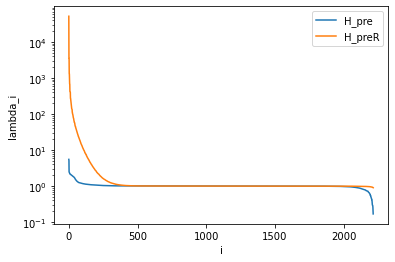

In [59]:
plt.figure()
plt.semilogy(ss_pre)
plt.semilogy(ss_preR)
plt.legend(['H_pre', 'H_preR'])
plt.xlabel('i')
plt.ylabel('lambda_i')

cond_pre = np.max(ss_pre)/np.min(ss_pre)
cond_preR = np.max(ss_preR)/np.min(ss_preR)

print('cond_pre=', cond_pre)
print('cond_preR=', cond_preR)

## Random RHS

In [60]:
krylov_iter=20
krylov_tol=1e-12

b = np.random.randn(V.dim())
x_true = np.linalg.solve(H_true, b)

x_R = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_reg = np.linalg.norm(x_true - x_R)/np.linalg.norm(x_true)
print('err_reg=', err_reg)

x_pre = spla.gmres(H_true, b, M=np.linalg.inv(H_approx), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
err_pre = np.linalg.norm(x_true - x_pre)/np.linalg.norm(x_true)
print('err_pre=', err_pre)

err_reg= 0.5665196484021608
err_pre= 1.200062188535667e-05


## Gradient RHS

Calling FFC just-in-time (JIT) compiler, this may take some time.


Text(0.5, 1.0, '-gradient at zero')

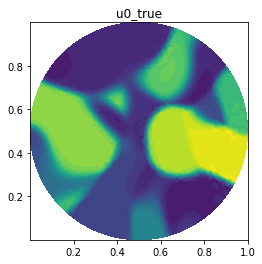

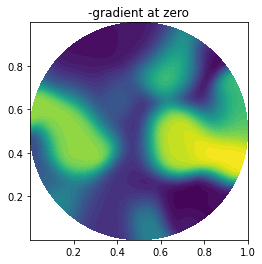

In [61]:
z0 = fenics.Function(V)

g_dual = gradient(z0.vector())
g = g_dual[:]
g_reisz = fenics.Function(V)
g_reisz.vector()[:] = solve_M(g_dual)

fenics.plot(u0_true)
plt.title('u0_true')

plt.figure()
fenics.plot(-g_reisz)
plt.title('-gradient at zero')

u0_err_reg= 0.25411206137677533
u0_err_pre= 0.03462167990746454


Text(0.5, 1.0, 'u0_pre_fct')

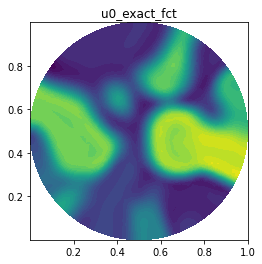

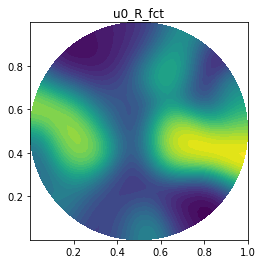

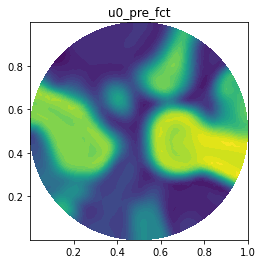

In [62]:
krylov_iter=5
krylov_tol=1e-12

b = np.random.randn(V.dim())
u0_exact = np.linalg.solve(H_true, -g)

u0_R = spla.gmres(H_true, -g, M=np.linalg.inv(Reg), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_reg = np.linalg.norm(u0_exact - u0_R)/np.linalg.norm(u0_exact)
print('u0_err_reg=', u0_err_reg)

u0_pre = spla.gmres(H_true, -g, M=np.linalg.inv(H_approx), restart=krylov_iter, maxiter=1, tol=krylov_tol)[0]
u0_err_pre = np.linalg.norm(u0_exact - u0_pre)/np.linalg.norm(u0_exact)
print('u0_err_pre=', u0_err_pre)

u0_exact_fct = fenics.Function(V)
u0_exact_fct.vector()[:] = u0_exact
fenics.plot(u0_exact_fct)
plt.title('u0_exact_fct')

plt.figure()
u0_R_fct = fenics.Function(V)
u0_R_fct.vector()[:] = u0_R
fenics.plot(u0_R_fct)
plt.title('u0_R_fct')

plt.figure()
u0_pre_fct = fenics.Function(V)
u0_pre_fct.vector()[:] = u0_pre
fenics.plot(u0_pre_fct)
plt.title('u0_pre_fct')

### Try deflating spectrum

In [63]:
H_pre2 = np.linalg.solve(H_approx, H_true)
U,ss,Vt = np.linalg.svd(H_pre2 - np.eye(V.dim()))

0

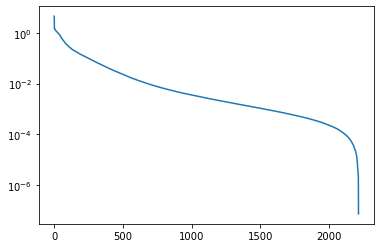

In [64]:
r2 = 5
plt.semilogy(ss)
np.sum(ss > r2)

In [65]:
P = H_approx2
delta_P = np.dot(P, np.dot(U[:,:r2], np.dot(np.diag(ss[:r2]), Vt[:r2,:])))
P2 = P + delta_P
H_pre3 = np.linalg.solve(P2, H_true)

NameError: name 'H_approx2' is not defined

In [ ]:
_,ll0,_ = np.linalg.svd(H_true)
_,ll1,_ = np.linalg.svd(P)
_,ll2,_ = np.linalg.svd(P2)

plt.semilogy(ll0)
plt.semilogy(ll1)
plt.semilogy(ll2)

In [ ]:
e0 = np.linalg.norm(P - H_true)/np.linalg.norm(H_true)
e1 = np.linalg.norm(P2 - H_true)/np.linalg.norm(H_true)
print('e0=', e0)
print('e1=', e1)

In [ ]:
import scipy.sparse.linalg as spla

# b_form = fenics.Expression('sin(5*x[0])*cos(3*x[1]) + x[0]*x[1]', degree=1)*fenics.TestFunction(V)*fenics.dx
# b = fenics.assemble(b_form)[:]
# b = np.random.randn(V.dim())
b = np.dot(H_true, ww[1].vector()[:])
b_fct = fenics.Function(V)
b_fct.vector()[:] = np.linalg.solve(M_numpy, b)
x_true = np.linalg.solve(H_true, b)

x_approx = np.linalg.solve(H_approx2, b)
x_approx3 = np.linalg.solve(P2, b)

err_approx = np.linalg.norm(x_true - x_approx)/np.linalg.norm(x_true)
print('err_approx=', err_approx)

err_approx3 = np.linalg.norm(x_true - x_approx3)/np.linalg.norm(x_true)
print('err_approx3=', err_approx3)

x_true_fct = fenics.Function(V)
x_true_fct.vector()[:] = x_true

x_approx_fct = fenics.Function(V)
x_approx_fct.vector()[:] = x_approx

x_approx3_fct = fenics.Function(V)
x_approx3_fct.vector()[:] = x_approx3

fenics.plot(x_true_fct)
plt.figure()
fenics.plot(x_approx_fct)
plt.figure()
fenics.plot(x_approx3_fct)

In [ ]:
fenics.plot(b_fct)

In [ ]:
iter = 20
krylov_tol = 1e-12

x0 = spla.gmres(H_true, b, restart=iter, maxiter=1, tol=krylov_tol)[0]
# x0 = spla.gmres(H_true, b, maxiter=iter)[0]
err0 = np.linalg.norm(x_true - x0)/np.linalg.norm(x_true)
# err0 = np.linalg.norm(np.dot(H_true,x0) - b)/np.linalg.norm(b)
print('err0=', err0)

x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x1 = spla.gmres(H_true, b, M=np.linalg.inv(Reg), maxiter=iter)[0]
# x1 = spla.minres(H_true, b, M=Reg, maxiter=iter)[0]
# x1 = spla.gmres(H_true, b, M=Reg, maxiter=iter)[0]
err1 = np.linalg.norm(x_true - x1)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x1) - b)/np.linalg.norm(b)
print('err1=', err1)

x2 = spla.gmres(H_true, b, M=np.linalg.inv((H_approx+H_approx.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv((P2+P2.T)/2.), restart=iter, maxiter=1, tol=krylov_tol)[0]
# x2 = spla.minres(H_true, b, M=np.linalg.inv(H_approx2), maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=np.linalg.inv(H_approx2), restart=iter, maxiter=1)[0]
# x2 = spla.minres(H_true, b, M=H_approx2, maxiter=iter)[0]
# x2 = spla.gmres(H_true, b, M=H_approx2, maxiter=iter)[0]
err2 = np.linalg.norm(x_true - x2)/np.linalg.norm(x_true)
# np.linalg.norm(np.dot(H_true,x2) - b)/np.linalg.norm(b)
print('err2=', err2)

x1_fct = fenics.Function(V)
x1_fct.vector()[:] = x1

fenics.plot(x1_fct)
plt.title('x1_fct')

plt.figure()
x2_fct = fenics.Function(V)
x2_fct.vector()[:] = x2

cm = fenics.plot(x2_fct)
plt.title('x2_fct')
plt.colorbar(cm)

plt.figure()
cm = fenics.plot(x_true_fct - x1_fct)
plt.colorbar(cm)
plt.title('err1 function')

plt.figure()
cm = fenics.plot(x_true_fct - x2_fct)
plt.colorbar(cm)
plt.title('err2 function')

In [ ]:
err0

In [ ]:
point_batches = list()
dirac_comb_responses = list()
dirac_comb_response_evaluators = list()
mu_batches = list()
Sigma_batches = list()
PSI = PoissonSquaredInterpolation(V)

def add_new_batch():
    new_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
    new_points = candidate_points[new_batch_inds, :]
    point_batches.append(new_points)
    candidate_inds = list(np.setdiff1d(candidate_inds, new_inds))

    mu_batches.append(eval_mu(new_points))
    all_Sigma_batches.append(eval_Sigma(new_points))
    
    new_dirac_comb_response = get_dirac_comb_response(new_batch_points)
    dirac_comb_responses.append(new_dirac_comb_response)
    dirac_comb_response_evaluators.append(FenicsFunctionFastGridEvaluator(new_dirac_comb_response))
    
    PSI.add_points([new_points[k,:] for k in range(new_points.shape[0])])
    

In [ ]:
PSI = PoissonSquaredInterpolation(V)

In [ ]:
latest_batch_inds = choose_sample_points_batch(cur_mu, cur_Sigma, num_std_dev_tau, np.array(candidate_inds))
latest_batch_of_points = candidate_points[latest_batch_inds, :]

latest_mu_batch = eval_mu(latest_batch_of_points)
all_mu_batches.append(latest_mu_batch)

latest_Sigma_batch = eval_Sigma(latest_batch_of_points)
all_Sigma_batches.append(latest_Sigma_batch)

In [ ]:
latest_eta = fenics.Function(V)
latest_eta.vector()[:] = get_dirac_comb_response(latest_batch_of_points)
all_eta.append(latest_eta)

latest_eval_eta = FenicsFunctionFastGridEvaluator(latest_eta)
all_eval_eta.append(latest_eval_eta)

In [ ]:
PSI.add_points([latest_batch_of_points[k,:] for k in range(latest_batch_of_points.shape[0])])

In [ ]:
for k in range(latest_batch_of_points.shape[0]):
    plt.figure()
    cmap = fenics.plot(PSI.weighting_functions[k])
    plt.plot(latest_batch_of_points[k,0], latest_batch_of_points[k,1],'.')
    plt.colorbar(cmap)

In [ ]:
all_eval_ww = [FenicsFunctionFastGridEvaluator(w) for w in PSI.weighting_functions]

In [ ]:
all_batches_of_points.append(latest_batch_of_points)
all_eta.append(latest_eta)
candidate_inds = list(np.setdiff1d(candidate_inds, latest_batch_inds))

me.BPC = BatchProductConvolution(me.all_eval_eta, me.all_eval_ww,
                                 me.all_batches_of_points, me.all_mu_batches, me.all_Sigma_batches, me.tau)